In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras import optimizers
import cv2
from itertools import chain
import glob

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
kernel = np.ones((5,5),np.uint8)

In [3]:
pathTrain = "/kaggle/input/fingers/fingers/train/*"
pathTest = "/kaggle/input/fingers/fingers/test/*"
NUMBER_OF_CLASSES = 6
BATCH_SIZE = 32
EPOCHS = 50
#indice_to_label = {0:"0L", 1:"1L", 2:"2L", 3:"3L", 4:"4L", 5:"5L", 6:"0R", 7:"1R", 8:"2R", 9:"3R", 10:"4R", 11:"5R"}
indice_to_label = {0:"0", 1:"1", 2:"2", 3:"3", 4:"4", 5:"5"}
label_to_indice = {v:k for k,v in indice_to_label.items()}

In [4]:
def process_image(img,kernel):
    img = cv2.resize(img, (128, 128))
    img = cv2.GaussianBlur(img,(5,5),0)
    _,img = cv2.threshold(img,80,255,cv2.THRESH_BINARY)
    
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv
    
    
    img = img/255
    return img

def img_to_sample(img, kernel = None):
    img = img.astype(np.uint8)
    img = np.reshape(img, (128, 128))
    
    img = process_image(img, kernel)
    
    img = np.reshape(img, (128, 128, 1))
    return img

In [5]:
train_set = [(file[-6] ,img_to_sample(cv2.imread(file, 0))) for file in glob.glob(pathTrain)]
test_set = [(file[-6] ,img_to_sample(cv2.imread(file, 0))) for file in glob.glob(pathTest)]

In [6]:
X_Train = [t[1] for t in train_set]
X_Train = X_Train + X_Train[0:6000]
Y_Train = [label_to_indice[t[0]] for t in train_set]
Y_Train = Y_Train + Y_Train[0:6000]

X_Test = [t[1] for t in test_set]
X_Test = X_Test
Y_Test = [label_to_indice[t[0]] for t in test_set]
Y_Test = Y_Test

X_Train = np.array(X_Train)
Y_Train = to_categorical(Y_Train, num_classes = NUMBER_OF_CLASSES)
X_Test = np.array(X_Test)
Y_Test = to_categorical(Y_Test, num_classes = NUMBER_OF_CLASSES)

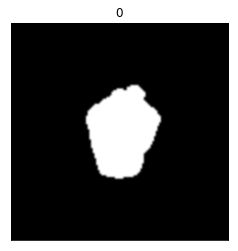

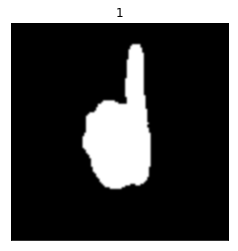

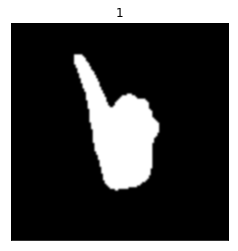

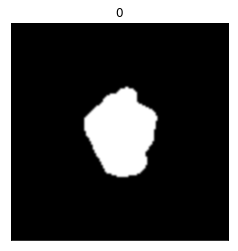

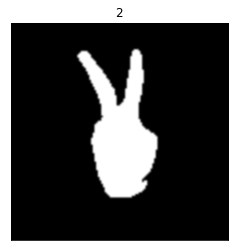

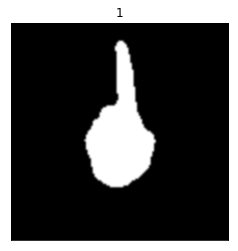

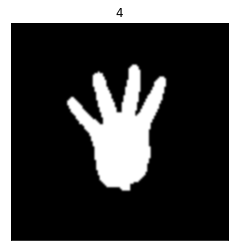

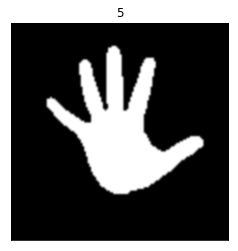

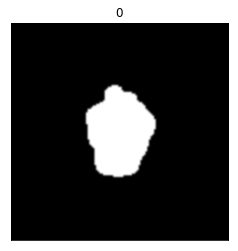

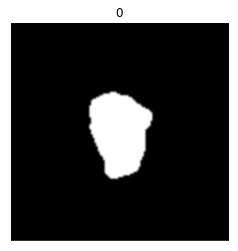

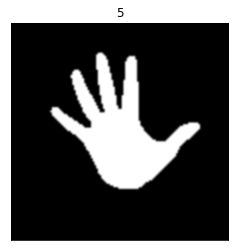

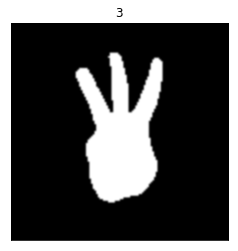

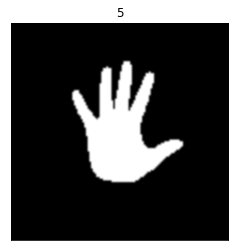

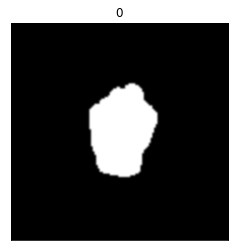

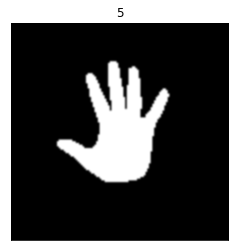

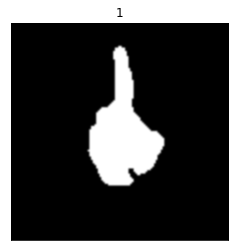

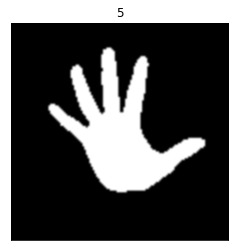

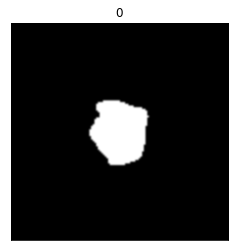

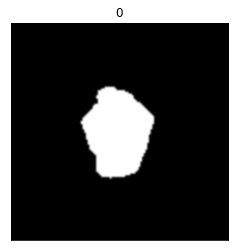

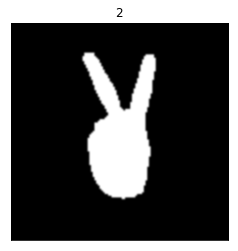

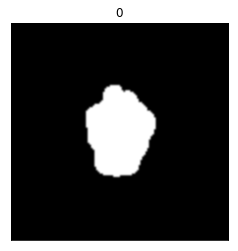

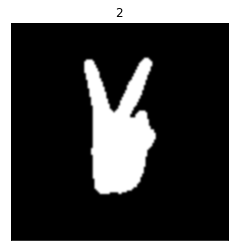

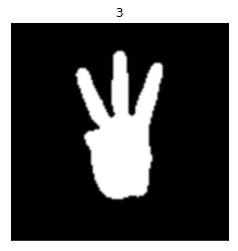

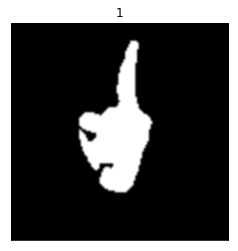

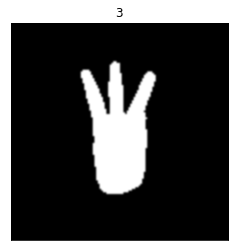

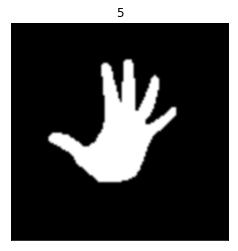

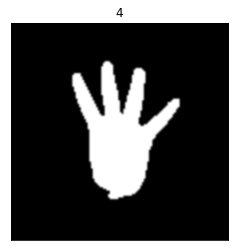

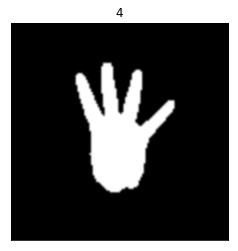

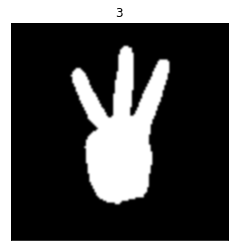

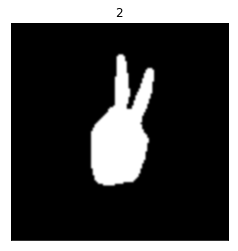

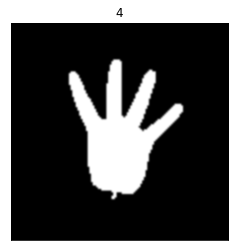

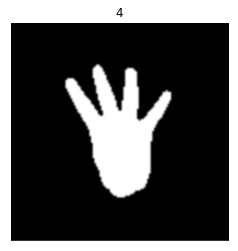

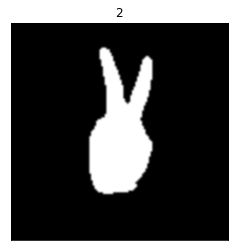

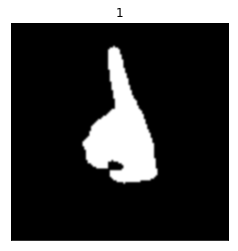

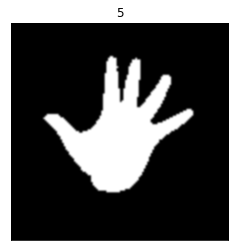

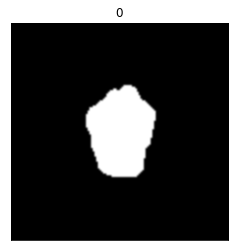

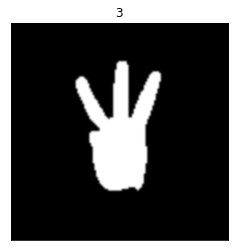

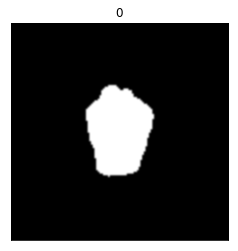

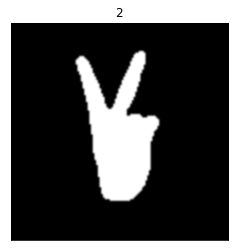

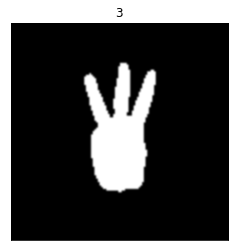

In [7]:
for i in range(20):
    plt.imshow(X_Train[i,:].reshape((128, 128)), cmap='gray', interpolation='bicubic')
    plt.title(indice_to_label[np.argmax(Y_Train[i])])
    plt.xticks([]), plt.yticks([])
    plt.show()
    
for i in range(20):
    plt.imshow(X_Test[i,:].reshape((128, 128)), cmap='gray', interpolation='bicubic')
    plt.title(indice_to_label[np.argmax(Y_Test[i])])
    plt.xticks([]), plt.yticks([])
    plt.show()

In [8]:
print(X_Train.shape)
print(Y_Train.shape)

print(X_Test.shape)
print(Y_Test.shape)

(24000, 128, 128, 1)
(24000, 6)
(3600, 128, 128, 1)
(3600, 6)


In [9]:
aug = ImageDataGenerator(
    rotation_range=45,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range = 0.1,
    horizontal_flip=False,
    fill_mode="nearest")

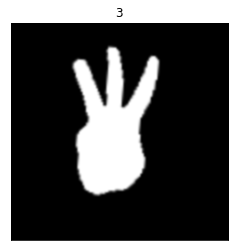

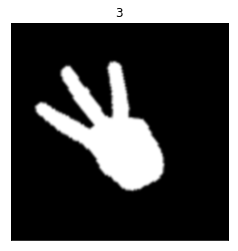

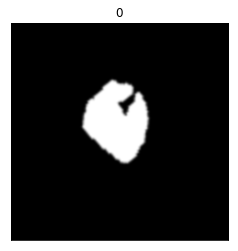

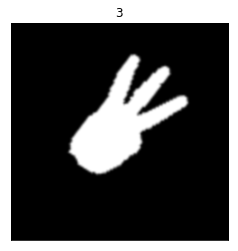

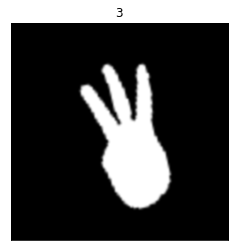

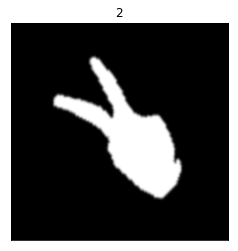

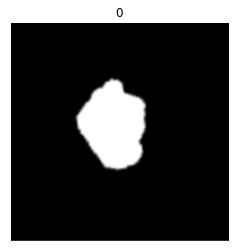

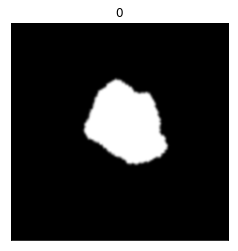

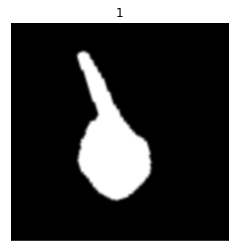

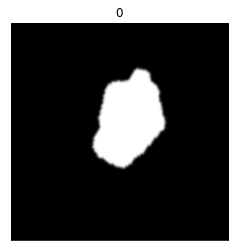

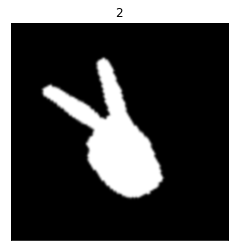

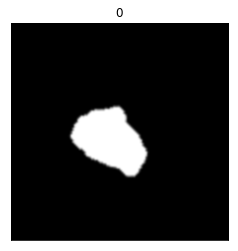

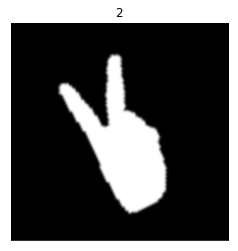

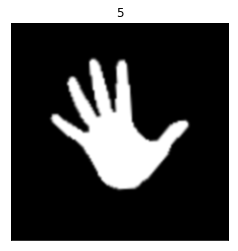

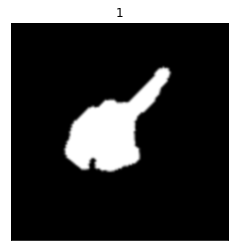

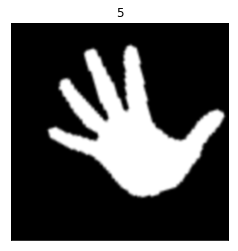

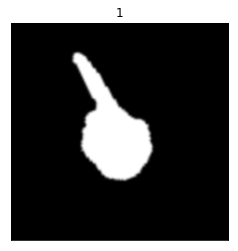

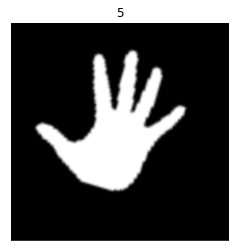

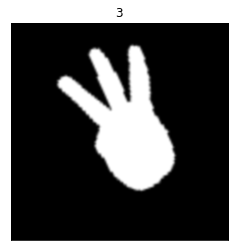

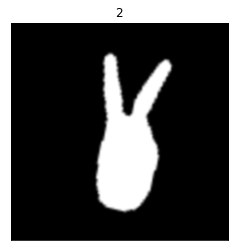

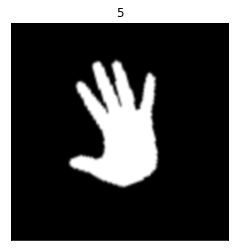

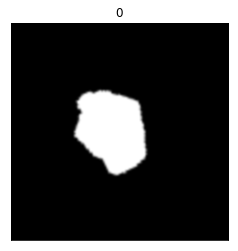

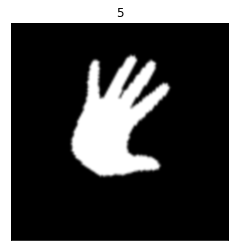

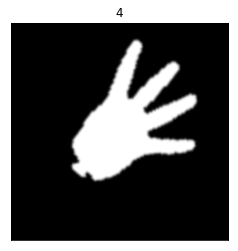

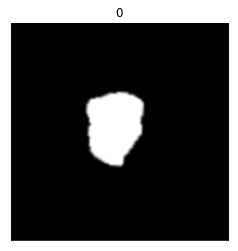

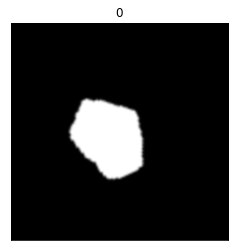

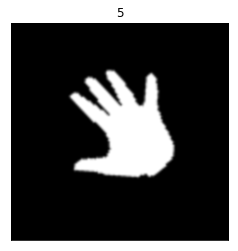

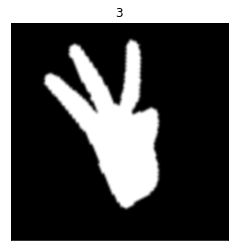

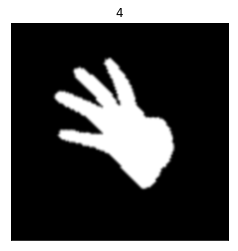

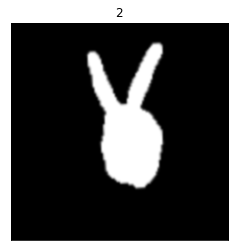

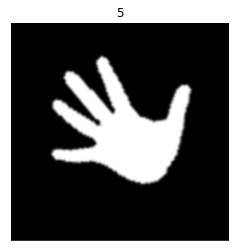

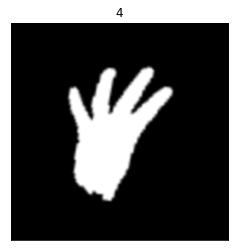

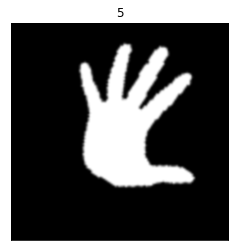

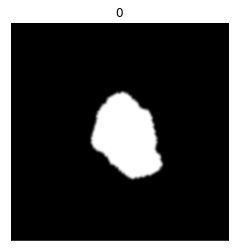

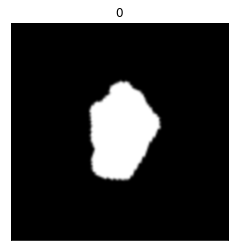

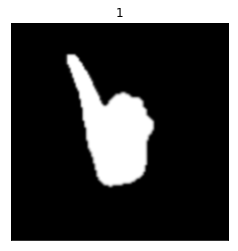

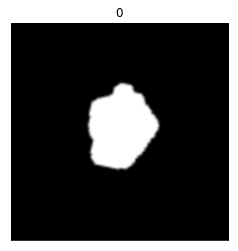

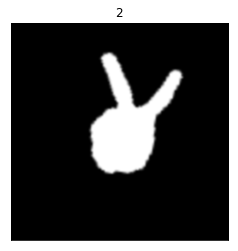

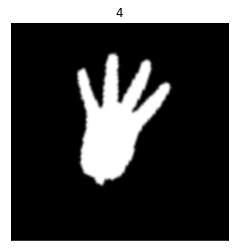

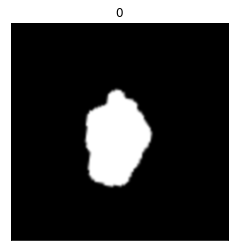

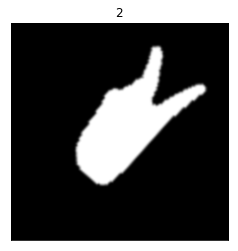

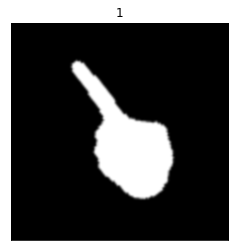

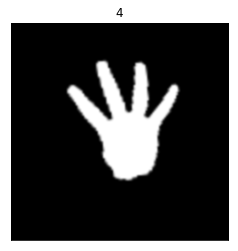

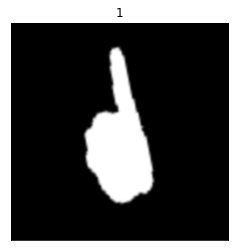

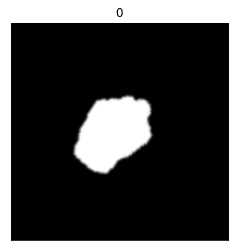

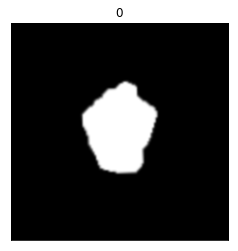

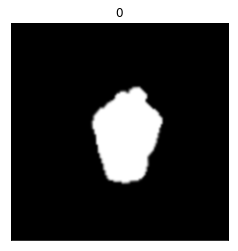

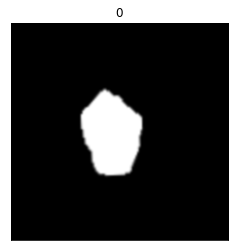

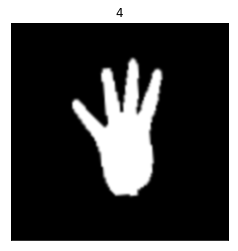

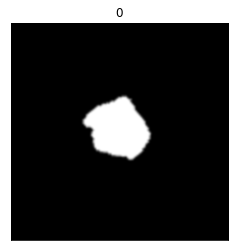

In [10]:
batches = 0
x_sample = X_Train[0:50]
y_sample = Y_Train[0:50]
batch = 1
for x_batch, y_batch in aug.flow(x_sample, y_sample, batch_size=batch):
        plt.imshow(x_batch[0,:].reshape((128, 128)), cmap='gray', interpolation='bicubic')
        plt.title(indice_to_label[np.argmax(y_batch[0])])
        plt.xticks([]), plt.yticks([])
        plt.show()
        batches += 1
        if batches >= len(x_sample) // batch:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

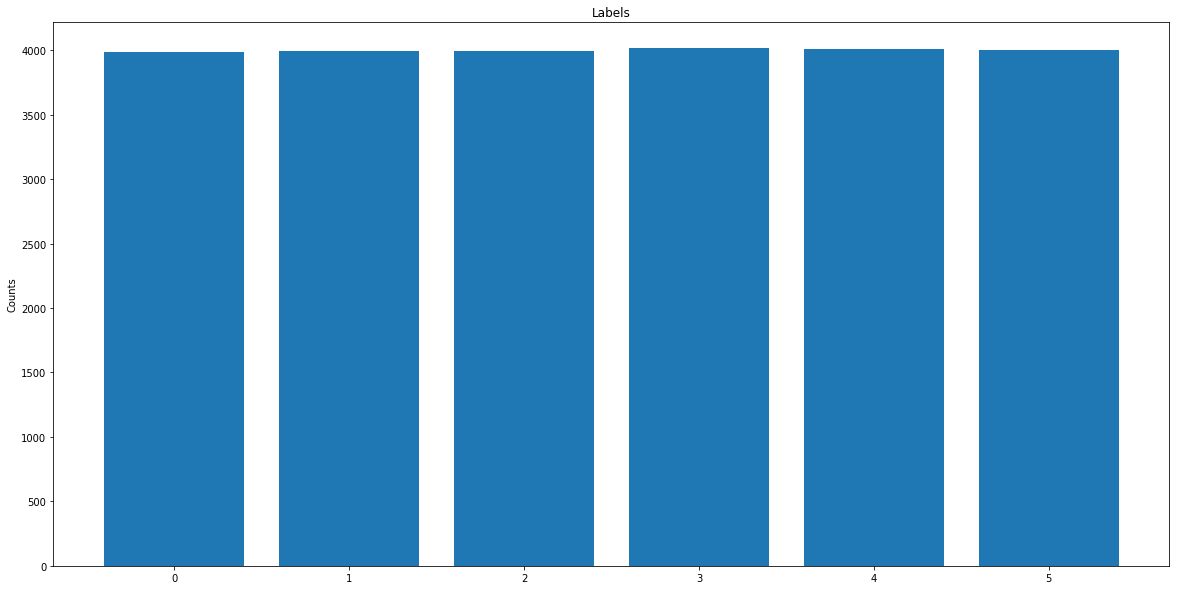

In [11]:
counts = Counter([x.argmax() for x in Y_Train])
plt.subplots(figsize = (20,10))
values = [k for k in counts.values()]
labels = [k for k in counts.keys()]
plt.bar(labels, values, align='center')
plt.ylabel('Counts')
plt.title('Labels')

plt.show()

In [12]:
def HandModel(input_shape):
    
    X_input = Input(input_shape, name = "input_layer")
    
    X = Conv2D(64, (3, 3), strides = (1, 1), activation='relu')(X_input)
    X = BatchNormalization()(X)
    
    X = Conv2D(64, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(64, (5, 5), strides = (2, 2), padding="same", activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.2)(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Conv2D(128, (5, 5), strides = (2, 2), padding="same", activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.3)(X)

    X = Flatten()(X)
    
    X = Dense(256, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dense(128, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.4)(X)
    
    X = Dense(NUMBER_OF_CLASSES, activation='softmax', name='output_layer')(X)

    model = Model(inputs = X_input, outputs = X, name='HandModel')

    return model

In [13]:
model = HandModel(X_Train.shape[1:])

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 64)        256       
__________

In [15]:
sgd = optimizers.SGD(lr=0.01, nesterov=True)

In [16]:
model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics = ["accuracy"])

with open('handmodel_fingers_architecture.json', 'w') as f:
    f.write(model.to_json())
    
filename = "handmodel_fingers_weights.hdf5"
checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

In [17]:
history = model.fit_generator(generator = aug.flow(X_Train, Y_Train, batch_size=BATCH_SIZE), steps_per_epoch= X_Train.shape[0] // BATCH_SIZE, validation_data=aug.flow(X_Test, Y_Test, batch_size=BATCH_SIZE), validation_steps = X_Test.shape[0] // BATCH_SIZE, epochs = EPOCHS, callbacks=callbacks_list)

Epoch 1/50
750/750 [==============================] - 81s 109ms/step - loss: 0.3069 - acc: 0.8918 - val_loss: 0.2157 - val_acc: 0.9169

Epoch 00001: loss improved from inf to 0.30691, saving model to handmodel_fingers_weights.hdf5
Epoch 2/50
750/750 [==============================] - 77s 102ms/step - loss: 0.0757 - acc: 0.9766 - val_loss: 0.0362 - val_acc: 0.9961

Epoch 00002: loss improved from 0.30691 to 0.07569, saving model to handmodel_fingers_weights.hdf5
Epoch 3/50
750/750 [==============================] - 77s 102ms/step - loss: 0.0502 - acc: 0.9847 - val_loss: 0.2016 - val_acc: 0.9627

Epoch 00003: loss improved from 0.07569 to 0.05024, saving model to handmodel_fingers_weights.hdf5
Epoch 4/50
750/750 [==============================] - 77s 103ms/step - loss: 0.0430 - acc: 0.9861 - val_loss: 0.0238 - val_acc: 0.9955

Epoch 00004: loss improved from 0.05024 to 0.04295, saving model to handmodel_fingers_weights.hdf5
Epoch 5/50
750/750 [==============================] - 77s 102ms/

In [18]:
#history = model.fit(x = X_Train, y = Y_Train, validation_data=(X_Test, Y_Test), batch_size = BATCH_SIZE, epochs = EPOCHS, callbacks=callbacks_list)

In [19]:
ev = model.evaluate(X_Test, Y_Test)

print("Loss : ",ev[0])
print("Accuracy : {} %".format(ev[1]*100))

ev

3600/3600 [==============================] - 4s 1ms/step
Loss :  0.012996874614618719
Accuracy : 99.97222222222221 %


[0.012996874614618719, 0.9997222222222222]

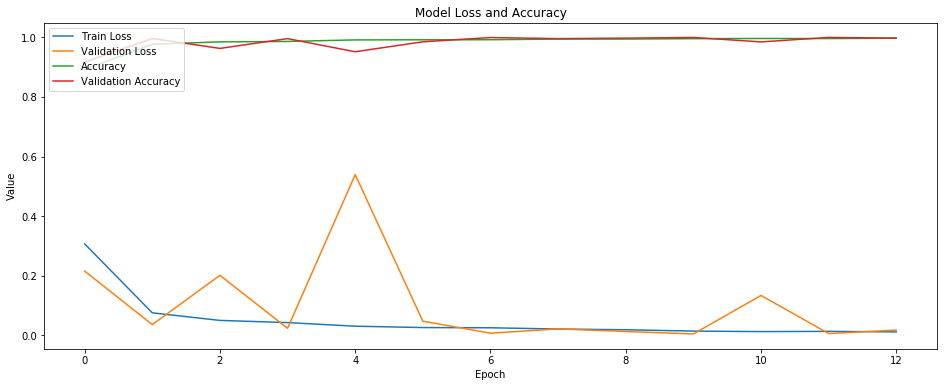

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', "Accuracy", "Validation Accuracy"], loc='upper left')
plt.savefig('training.png')
plt.show()

In [21]:
model.save('handmodel_fingers_model.h5')

In [22]:
preds = model.predict(X_Test)
preds = (preds > 0.5).astype(int)

In [23]:
y_preds = [l.index(1) if 1 in l else 0 for l in preds.tolist()]
y_true = [l.index(1) for l in Y_Test.tolist()]

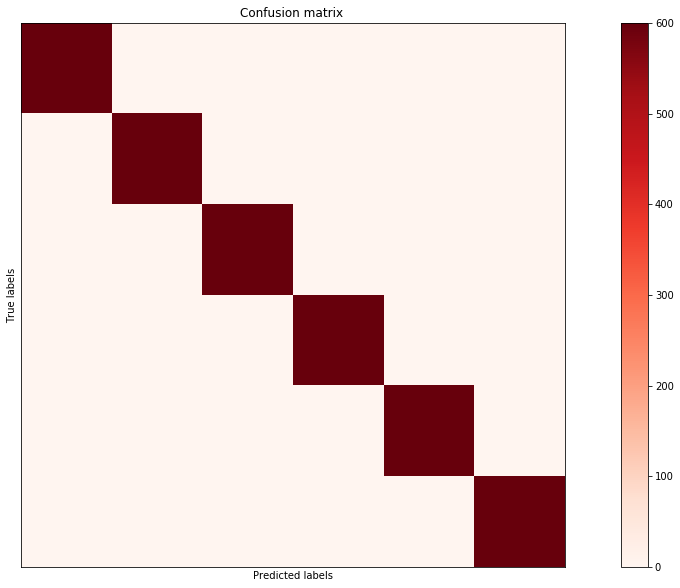

In [24]:
cm = confusion_matrix(y_true, y_preds)

plt.subplots(figsize=(20, 10))
plt.imshow(cm, cmap=plt.cm.Reds)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.savefig('testing.png', bbox_inches='tight')
plt.show()